**CS 6375 - Assignment 1 - Part02 - Enhance a neural network's performance by experimenting with different hyperparameter combinations.**

Submitted by:-Deep Padmani(DMP210005), Aarushi Nagpure(AXN220015), Rubina Parveen(RXL220014)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Information about the project
'''
Dataset Vehicle dataset:
Kaggle Machine Learning Repository. https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho
The dataset contains 4340 data points collected form websites.

Dataset Information:
The dataset contains 4340 data points collected form websites, Features consist variables Car Name (Car_Name), Year (Year), Present Price (Present_Price),Driven Kilometer (Kms_Driven), Fuel Type (Fuel_Type), Seller Type(Seller_Type) , Transmission(Transmission),Owner(Owner) and  to predict Selling Price (Selling_Price).

Target Variable:
Selling Price (Selling_Price)

References:
1.	https://towardsdatascience.com/building-a-shallow-neural-network-a4e2728441e0
2.	https://numpy.org/
3.	https://medium.com/deeplearning-notepad/a-beginners-guide-to-shallow-neural-network-bde80c868ac9
4.  https://pandas.pydata.org/

'''

**Various Activation & Loss Functions and Their Derivations**

In [ ]:
# Activation functions
def Sigmoid(xVar):
    return 1 / (1 + np.exp(-xVar))

def derivationOfSigmoid(xVar):
    sigmoidVar = 1 / (1 + np.exp(-xVar))
    return sigmoidVar * (1 - sigmoidVar)

def Tanh(xVar):
    return np.tanh(xVar)

def derivationOfTanh(xVar):
    return 1 - np.tanh(xVar) ** 2

def ReLu(xVar):
    return np.maximum(0,xVar)

def derivationOfRelu(xVar):
    return np.where(xVar <= 0, 0, 1)

# Loss function and its derivative
def Loss(actualsOf_Y, predictionsOf_Y):
    return np.sum(np.square(actualsOf_Y -  predictionsOf_Y)) / 2

def derivationOfLoss(actualsOf_Y, predictionsOf_Y):
    return (predictionsOf_Y - actualsOf_Y)

**Neural Network Code**

In [ ]:
# Neural Network class
class NeuralNetwork():
    def __init__(self, data, noOfAttribute, hiddenNodes, noOfOutput,activationFunction,derivationOfActivationFunction ,learningRate, Loss, derivationOfLoss,sizeOfBatch,beta1,beta2,epsilon) -> None:
        self.data = data
        self.noOfAttribute = noOfAttribute
        self.hiddenNodes = hiddenNodes
        self.noOfOutput = noOfOutput
        self.activationFunction = activationFunction
        self.derivationOfActivationFunction = derivationOfActivationFunction
        self.learningRate = learningRate
        self.inputsOfNormalized = None
        self.outputsOfNormalized = None
        self.sizeOfBatch = sizeOfBatch
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.Xtrain = None
        self.Xtest = None
        self.Ytrain = None
        self.Ytest = None

        self.scaler = StandardScaler()

        self.Loss = Loss
        self.derivationOfLoss = derivationOfLoss

    # Data preprocessing methods
    def normalize(self, inputs, outputs):
        inputsOfNormalized = self.scaler.fit_transform(inputs)
        outputsOfNormalized = self.scaler.fit_transform(outputs)

        return inputsOfNormalized, outputsOfNormalized

    def printCorrelationMatrix(self):
        # Cleaning the data
        self.dataCleaning()
        # establishing a relationship between each characteristic
        matrixOfCorrelation = self.data.corr()
        plt.figure(figsize=(10, 10))
        sns.heatmap(matrixOfCorrelation, annot=True, cmap="RdBu", linewidths=0.5)
        plt.title("Heatmap")
        plt.show()

    def dataCleaning(self):
        # Cleaning the data
        print("Null values exist") if self.data.isna().any().any() else print("Not a single null value exists")

        self.data['Fuel_Type'].replace('Petrol', 0, inplace=True)
        self.data['Fuel_Type'].replace('Diesel', 1, inplace=True)
        self.data['Fuel_Type'].replace('CNG', 2, inplace=True)

        self.data['Transmission'].replace('Manual', 0, inplace=True)
        self.data['Transmission'].replace('Automatic', 1, inplace=True)
        self.newDataFrame = self.data.drop(labels=["Seller_Type","Car_Name"], axis=1)

        self.newDataFrame = self.newDataFrame.drop(labels=["Selling_Price"], axis=1)

        inputs =  np.array(self.newDataFrame)
        outputs = np.array(self.data["Selling_Price"])


        outputs = outputs.reshape(len(outputs), 1)

        self.inputsOfNormalized, self.outputsOfNormalized = self.normalize(inputs, outputs)

    # The entire set of data will be divided into training and testing sets using this function.
    def split(self, percentageOfSplit):
        self.Xtrain, self.Xtest, self.Ytrain, self.Ytest = train_test_split(self.inputsOfNormalized, self.outputsOfNormalized, test_size=percentageOfSplit)


    def initializeWeights(self):
        self.w1 = np.random.rand(self.noOfAttribute, self.hiddenNodes) * (np.sqrt(2. / self.noOfAttribute))
        self.w2 = np.random.rand(self.noOfOutput, self.hiddenNodes) *  (np.sqrt(2. / self.noOfAttribute))

        self.b1 = np.zeros((1, self.hiddenNodes))
        self.b2 = np.zeros((1, self.noOfOutput))

        # Initializing velcocity and rms prop for ADAM
        self.Vdw = np.zeros((self.w1.shape[0], self.w1.shape[1]))
        self.Vdb = np.zeros((self.b1.shape[0], self.b1.shape[1]))

        self.Sdw = np.zeros((self.w1.shape[0], self.w1.shape[1]))
        self.Sdb = np.zeros((self.b1.shape[0], self.b1.shape[1]))

    def forwardPass(self, X):
        self.X = X
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = self.activationFunction(self.z1)

        self.z2 = np.dot(self.a1, self.w2.T) + self.b2

        return self.z2

    def backwardPass(self, initError,t):
        # calculating out the output layer's gradients
        dz2 = initError
        dw2 = np.dot(dz2.T, self.a1) / self.X.shape[0]
        db2 = np.sum(dz2, axis=0, keepdims=True) / self.X.shape[0]

        # Setting weights for output layers
        self.w2 -= (self.learningRate * dw2)
        self.b2 -= (self.learningRate * db2)

        # calculating out the hidden layer's gradients
        da1 = np.dot(dz2, self.w2)

        dz1 = da1 * self.derivationOfActivationFunction(self.z1)
        dw1 = np.dot(self.X.T, dz1) / self.X.shape[0]
        db1 = np.sum(dz1, axis=0, keepdims=True) / self.X.shape[0]


        # updating ADAM's velocity and rms prop
        self.Vdw = self.beta1 * self.Vdw + (1 - self.beta1) * dw1
        self.Vdb = self.beta1 * self.Vdb + (1 - self.beta1) * db1

        # Correcting for bias in velocity and rms prop
        revisedVdw = self.Vdw / (1 - (self.beta1 ** t))
        revisedVdb = self.Vdb / (1 - (self.beta1 ** t))

        self.Sdw = self.beta2 * self.Sdw + ((1 - self.beta2) * np.square(dw1))
        self.Sdb = self.beta2 * self.Sdb + ((1 - self.beta2) * np.square(db1))

        revisedSdw = self.Sdw / (1 - (self.beta2 ** t))
        revisedSdb = self.Sdb / (1 - (self.beta2 ** t))



        # Setting weights for output layers
        self.w1 -= (self.learningRate * revisedVdw) / np.sqrt(revisedSdw + self.epsilon)
        self.b1 -= (self.learningRate * revisedVdb) / np.sqrt(revisedSdb + self.epsilon)

    def predict(self, dataInput):
        predictions = self.forwardPass(dataInput)
        return predictions

    def generate_batches(self):
        miniBatches = []
        noOfExamples = self.Xtrain.shape[0]
        noOfBatches = noOfExamples // self.sizeOfBatch
        leftover = noOfExamples % self.sizeOfBatch

        for BatcheIdx in range(noOfBatches):
            startIdx = BatcheIdx * self.sizeOfBatch
            endIdx = (BatcheIdx + 1) * self.sizeOfBatch

            miniBatchX = self.Xtrain[startIdx:endIdx, :]
            miniBatchY = self.Ytrain[startIdx:endIdx, :]
            miniBatches.append((miniBatchX, miniBatchY))

        if leftover > 0:
            lastMiniBatchX = self.Xtrain[-leftover:, :]
            lastMiniBatchY = self.Ytrain[-leftover:, :]
            miniBatches.append((lastMiniBatchX, lastMiniBatchY))

        return miniBatches

    def train(self, epochs):
        self.initializeWeights()

        # Cleaning the data
        self.dataCleaning()

        # Splitting the data into training and testing
        self.split(percentageOfSplit=0.2)

        miniBatches = self.generate_batches()

        historyOfCost = []

        t = 0
        # Iterating into the given number of epochs
        for _ in range(epochs):
              t += 1
              for batch in miniBatches:
                    minXtrain, minYtrain = batch
                    # Forward Propogation
                    output = self.forwardPass(minXtrain)

                    # Cost Calculation
                    cost = self.  (minYtrain, output)

                    # Backward Propogation
                    initError = self.derivationOfLoss(minYtrain, output)
                    self.backwardPass(initError,t)
              historyOfCost.append(cost)

        print("The following are the train scores:")
        predictionsOftraining = self.predict(self.Xtrain)
        print(f"Mean Square Error: {mean_squared_error(self.Ytrain, predictionsOftraining)}")
        print(f"Mean Absolute Error: {mean_absolute_error(self.Ytrain, predictionsOftraining)}")
        print(f"R square Fit:  {r2_score(self.Ytrain, predictionsOftraining)}")
        print(f"Loss: {historyOfCost[-1]}")

        print("\nThe following are the Test scores:")
        predictionsOftest = self.predict(self.Xtest)
        print(f"Mean Square Error: {mean_squared_error(self.Ytest, predictionsOftest)}")
        print(f"Mean Absolute Error: {mean_absolute_error(self.Ytest, predictionsOftest)}")
        print(f"R square Fit: {r2_score(self.Ytest, predictionsOftest)}")



        # Plotting the Epoch vs. Loss Diagram
        font1 = {'family':'serif','color':'blue','size':20}
        font2 = {'family':'serif','color':'darkred','size':15}
        plt.plot(range(1, epochs+1), historyOfCost, color='red')
        plt.grid()
        plt.xlabel('Epochs',fontdict = font2)
        plt.ylabel('Cost (Loss)', fontdict = font2)
        plt.title('Epochs vs. Cost', fontdict = font1)
        plt.show()

**Preparing the dataset for training and testing**

Not a single null value exists


<ipython-input-66-e5f1510d7310>:39: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrixOfCorrelation = self.data.corr()


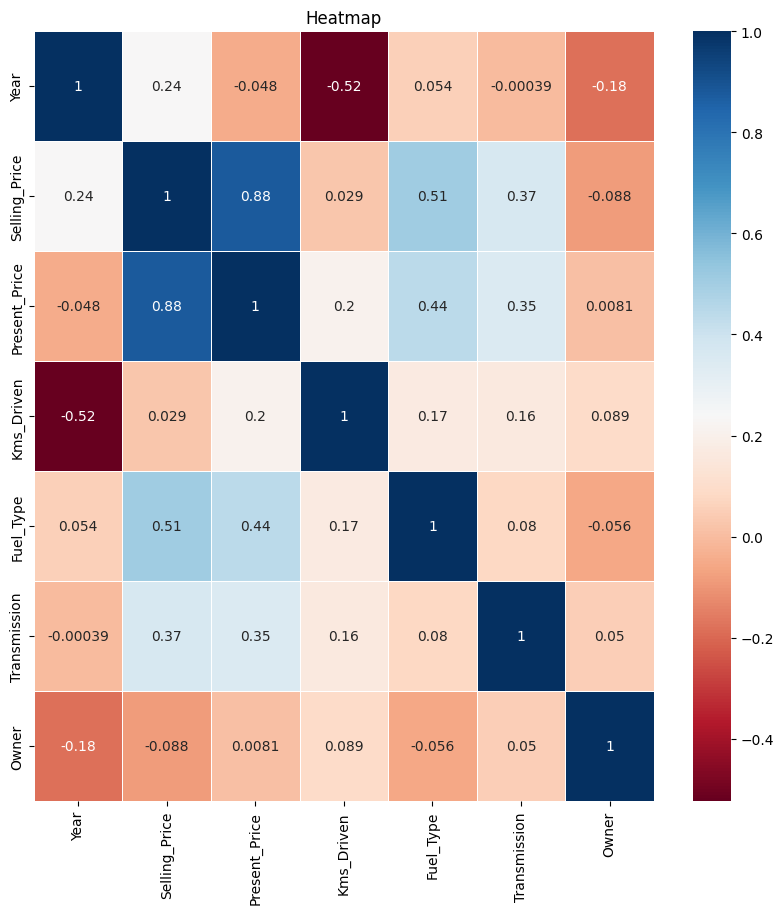

******* Neural Network Using ReLu *******
Not a single null value exists
The following are the train scores:
Mean Square Error: 0.007633562653840233
Mean Absolute Error: 0.060100424634274716
R square Fit:  0.9902092432192875
Loss: 0.08668527848668932

The following are the Test scores:
Mean Square Error: 0.8752351720578492
Mean Absolute Error: 0.2765187849562531
R square Fit: 0.5096065770838842


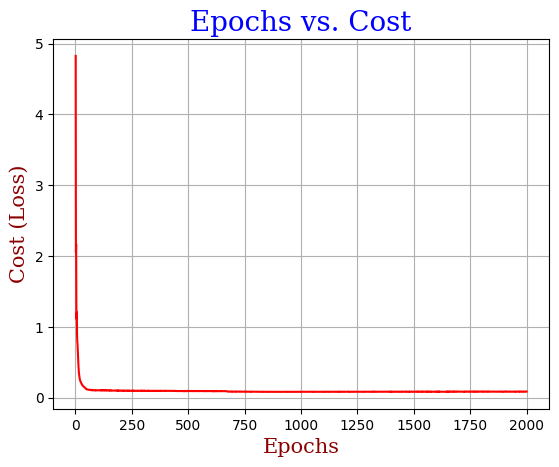

******* Neural Network Using Tanh *******
Not a single null value exists
The following are the train scores:
Mean Square Error: 0.00436466069398231
Mean Absolute Error: 0.04759614257672086
R square Fit:  0.9959633248612316
Loss: 0.020707197270164235

The following are the Test scores:
Mean Square Error: 0.06125603205964517
Mean Absolute Error: 0.1463122372392019
R square Fit: 0.9098946852280981


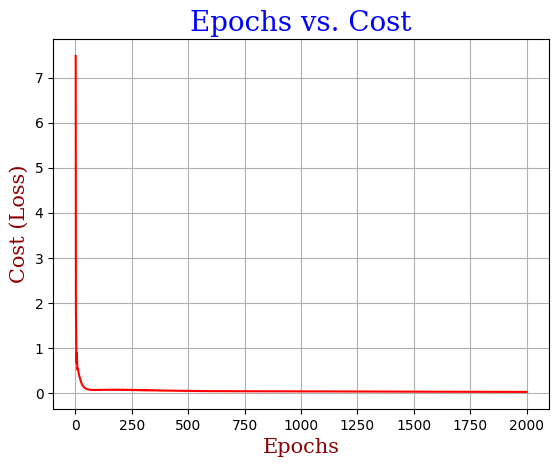

******* Neural Network Using Sigmoid *******
Not a single null value exists
The following are the train scores:
Mean Square Error: 0.006648261075692386
Mean Absolute Error: 0.056512810597523305
R square Fit:  0.9929312997382419
Loss: 0.04110698705355841

The following are the Test scores:
Mean Square Error: 0.04104387902901745
Mean Absolute Error: 0.12194049348456895
R square Fit: 0.9666736277596203


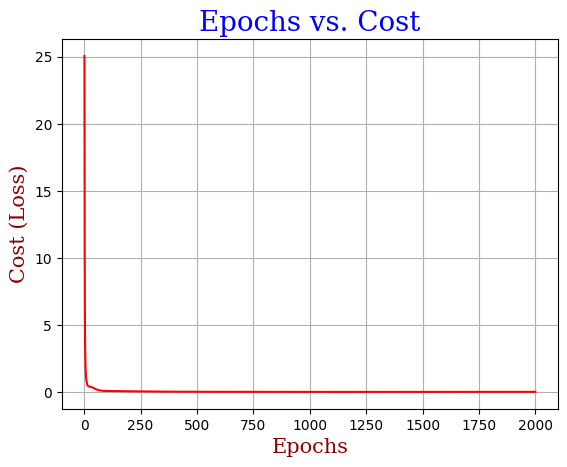

In [ ]:
if __name__ == "__main__":
    fileName = "https://raw.githubusercontent.com/deeppadmani/Datasets/main/CarDataset/cardata.csv"
    data = pd.read_csv(fileName)


    NeuralNetNo1 = NeuralNetwork(data=data, hiddenNodes=18, noOfAttribute=6, noOfOutput=1, activationFunction=ReLu, derivationOfActivationFunction=derivationOfRelu, learningRate=0.01, Loss=Loss, derivationOfLoss=derivationOfLoss,sizeOfBatch=32, beta1=0.9, beta2=0.9, epsilon=1e-8)
    NeuralNetNo1.printCorrelationMatrix()
    print("******* Neural Network Using ReLu *******")
    NeuralNetNo1.train(2000)

    print("******* Neural Network Using Tanh *******")
    NeuralNetNo2 = NeuralNetwork(data=data, hiddenNodes=18, noOfAttribute=6, noOfOutput=1, activationFunction=Tanh, derivationOfActivationFunction=derivationOfTanh, learningRate=0.01, Loss=Loss, derivationOfLoss=derivationOfLoss,sizeOfBatch=32, beta1=0.9, beta2=0.9, epsilon=1e-8)
    NeuralNetNo2.train(2000)

    print("******* Neural Network Using Sigmoid *******")
    NeuralNetNo3 = NeuralNetwork(data=data, hiddenNodes=18, noOfAttribute=6, noOfOutput=1, activationFunction=Sigmoid, derivationOfActivationFunction=derivationOfSigmoid, learningRate=0.01, Loss=Loss, derivationOfLoss=derivationOfLoss,sizeOfBatch=32, beta1=0.9, beta2=0.9, epsilon=1e-8)
    NeuralNetNo3.train(2000)